# Latar Belakang

## Pernyataan Masalah

Suatu perusahaan asuransi penerbangan ingin mengetahui **tingkat kecelakaan pesawat dan pola ganti rugi pada kecelakaan presawat**. Informasi ini berguna untuk mengetahui pola ganti rugi yang dibutuhkan suatu maskapai penerbangan apabila terjadi suatu kecelakaan dan seperti apa pola kecelakaan pesawat.

Sebagai seorang data analyst, kita akan mencoba menjawab pertanyaan berikut:

1. **Seperti apa pola terjadinya kecelakaan pesawat**
2. **Apa yang menyebabkan tingkat ganti rugi**
3. **Tingkat kepedulian bandara menyikapi suatu kecelakaan**


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime as dt

# Data

Pertanyaan diatas dapat di jawab dengan menganaliasa data transaksi mobil yang sudah dilakukan oleh perusahaan. Dataset dapat di akses [disini](https://www.kaggle.com/datasets/terminal-security-agency/tsa-claims-database)

Dataset ini berisi tentang karakteristik insiden yang terjadi di bandara. Berikut kolom kolom pada dataset yaitu:
1.	Claim Number $~~$:$~~$	ID Column
2.	Date Received $~~$:$~~$	Tanggal Laporan
3.	Incident Date $~~~$:$~~$	Tanggal Kejadian
4.	Airport Code $~~~~$:$~~$	Nama Bandara
6.	Airline Name $~~~~$:$~~$	Nama Maskapai Penerbangan
7.	Claim Type $~~~~~~~$:$~~$	Tipe Pengaduan
8.	Claim Site $~~~~~~~~$:$~~$	Tempat Aduan
9.	Item $~~~~~~~~~~~~~~~~$:$~~$	Item
10.	Claim Amount $~~$:$~~$	Jumlah Permintaan Ganti Rugi
11.	Status $~~~~~~~~~~~~~~$:$~~$	Status Ganti Rugi
12.	Close Amount $~~$:$~~$	Nominan yang Dibayarkan
13.	Disposition $~~~~~~$:$~~$	Pengaturan Ganti Rugi


In [2]:
df = pd.read_csv("D:\\Belajar_Purwadika\\capstone_modul2\\tsa_claims.csv")
df.head()


C:\Users\pudyo\AppData\Local\Temp\ipykernel_17636\2955685780.py:1: DtypeWarning: Columns (0,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("D:\\Belajar_Purwadika\\capstone_modul2\\tsa_claims.csv")


,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Item,Claim Amount,Status,Close Amount,Disposition
0,0909802M,4-Jan-02,12/12/2002 0:00,EWR,Newark International Airport,Continental Airlines,Property Damage,Checkpoint,Other,$350.00,Approved,$350.00,Approve in Full
1,0202417M,2-Feb-02,1/16/2004 0:00,SEA,Seattle-Tacoma International,NaN,Property Damage,Checked Baggage,Luggage (all types including footlockers),$100.00,Settled,$50.00,Settle
2,0202445M,4-Feb-02,11/26/2003 0:00,STL,Lambert St. Louis International,American Airlines,Property Damage,Checked Baggage,Cell Phones,$278.88,Settled,$227.92,Settle
3,0909816M,7-Feb-02,1/6/2003 0:00,MIA,Miami International Airport,American Airlines,Property Damage,Checkpoint,Luggage (all types including footlockers),$50.00,Approved,$50.00,Approve in Full
4,2005032379513,18-Feb-02,2/5/2005 0:00,MCO,Orlando International Airport,Delta (Song),Property Damage,Checkpoint,Baby - Strollers; car seats; playpen; etc.,$84.79,Approved,$84.79,Approve in Full


## Data Cleaning

Proses ini bertujuan untuk mengenal dan mengidentifikasi data yang dimiliki, baik berupa anomali data dan cara penanggulangannya baik dengan metode statistik maupun *domain Knowlage*, jumlah klasifikasi data, dan statistika dari data (median, modus, dll)

### Identifikasi data

In [3]:
dfDesc=[]
for i in df.columns:
    dfDesc.append([i,
                     df[i].dtypes,
                     df[i].isna().sum(),
                     df[i].nunique(),
                     df[i].drop_duplicates().sample(2).values])
pd.DataFrame(dfDesc, columns=['Nama Kolom', 'Tipe Data', 'Jumlah Null', 'Jumlah Unique Value','Contoh Unique Value'])

,Nama Kolom,Tipe Data,Jumlah Null,Jumlah Unique Value,Contoh Unique Value
0,Claim Number,object,0,204258,"[2004070758711, 2004053153922]"
1,Date Received,object,263,4007,"[22-Dec-14, 13-Sep-13]"
2,Incident Date,object,2183,26807,"[7/1/2002 0:00, 12/19/2010 0:00]"
3,Airport Code,object,8524,465,"[RIC, MCO]"
4,Airport Name,object,8524,485,"[Evansville Regional Airport, Washington Dulle..."
5,Airline Name,object,34374,318,"[USA 3000 (U5), KLM Royal Dutch Airlines ]"
6,Claim Type,object,7913,11,"[Personal Injury, Complaint]"
7,Claim Site,object,740,6,"[nan, Other]"
8,Item,object,3966,4704,"[Briefcases; Locks; Locks, Cameras - Digital; ..."
9,Claim Amount,object,4043,36117,"[$48.72 , $167.70 ]"


### Null Handling dam Data Cleaning

In [4]:
df.dropna(axis = 0, thresh= 2, inplace = True)

In [5]:
# Merubah variable "-"" menjadi nan
for i in (df.columns):
    for j in df.index:
        if df[i][j] == '-':
            df[i][j] = np.nan

In [6]:
# Merubah format data Claim Amount menjadi numerk dan mengganti nilai kosong menjadi angka 0
df['Claim Amount'] = df['Claim Amount'].str.replace('$', '').str.replace(' ', '').str.replace(';', '').str.replace(',', '.')
df['Claim Amount'] = df['Claim Amount'].str.replace('-', '0')
df['Claim Amount'] = pd.to_numeric(df["Claim Amount"])
df['Claim Amount'].fillna(0, inplace=True)
df.head()

C:\Users\pudyo\AppData\Local\Temp\ipykernel_17636\496135688.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Claim Amount'] = df['Claim Amount'].str.replace('$', '').str.replace(' ', '').str.replace(';', '').str.replace(',', '.')


,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Item,Claim Amount,Status,Close Amount,Disposition
0,0909802M,4-Jan-02,12/12/2002 0:00,EWR,Newark International Airport,Continental Airlines,Property Damage,Checkpoint,Other,350.00,Approved,$350.00,Approve in Full
1,0202417M,2-Feb-02,1/16/2004 0:00,SEA,Seattle-Tacoma International,NaN,Property Damage,Checked Baggage,Luggage (all types including footlockers),100.00,Settled,$50.00,Settle
2,0202445M,4-Feb-02,11/26/2003 0:00,STL,Lambert St. Louis International,American Airlines,Property Damage,Checked Baggage,Cell Phones,278.88,Settled,$227.92,Settle
3,0909816M,7-Feb-02,1/6/2003 0:00,MIA,Miami International Airport,American Airlines,Property Damage,Checkpoint,Luggage (all types including footlockers),50.00,Approved,$50.00,Approve in Full
4,2005032379513,18-Feb-02,2/5/2005 0:00,MCO,Orlando International Airport,Delta (Song),Property Damage,Checkpoint,Baby - Strollers; car seats; playpen; etc.,84.79,Approved,$84.79,Approve in Full


In [7]:
# Merubah format data Close Amount menjadi numerk dan mengganti nilai kosong menjadi angka 0
df['Close Amount'] = df['Close Amount'].str.replace('$', '').str.replace(' ', '').str.replace(';', '').str.replace(',', '.')
df['Close Amount'].fillna(0, inplace=True)
df['Close Amount'] = pd.to_numeric(df["Close Amount"])
df.head()

C:\Users\pudyo\AppData\Local\Temp\ipykernel_17636\2878895411.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Close Amount'] = df['Close Amount'].str.replace('$', '').str.replace(' ', '').str.replace(';', '').str.replace(',', '.')


,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Item,Claim Amount,Status,Close Amount,Disposition
0,0909802M,4-Jan-02,12/12/2002 0:00,EWR,Newark International Airport,Continental Airlines,Property Damage,Checkpoint,Other,350.00,Approved,350.00,Approve in Full
1,0202417M,2-Feb-02,1/16/2004 0:00,SEA,Seattle-Tacoma International,NaN,Property Damage,Checked Baggage,Luggage (all types including footlockers),100.00,Settled,50.00,Settle
2,0202445M,4-Feb-02,11/26/2003 0:00,STL,Lambert St. Louis International,American Airlines,Property Damage,Checked Baggage,Cell Phones,278.88,Settled,227.92,Settle
3,0909816M,7-Feb-02,1/6/2003 0:00,MIA,Miami International Airport,American Airlines,Property Damage,Checkpoint,Luggage (all types including footlockers),50.00,Approved,50.00,Approve in Full
4,2005032379513,18-Feb-02,2/5/2005 0:00,MCO,Orlando International Airport,Delta (Song),Property Damage,Checkpoint,Baby - Strollers; car seats; playpen; etc.,84.79,Approved,84.79,Approve in Full


In [8]:
# Merubah nilai null pada kolom Airport Name, Airport Code, dan Airline Name

df['Airport Name'].fillna('Other', inplace=True)

df['Airport Code'].fillna('OTR', inplace=True)

df['Airline Name'].fillna('Unknown', inplace=True)

df.tail()

,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Item,Claim Amount,Status,Close Amount,Disposition
204262,2015120427297,20-Nov-15,16-Oct-15,OTR,Other,Unknown,Property Damage,Checked Baggage,Baggage/Cases/Purses; Books; Magazines & Other...,0.0,NaN,0.0,NaN
204263,2015123027969,17-Dec-15,2-Dec-15,OTR,Other,Unknown,Property Damage,Checked Baggage,Audio/Video; Home Decor,0.0,NaN,0.0,NaN
204264,2016010428072,22-Dec-15,20-Dec-15,OTR,Other,Unknown,Passenger Property Loss,Checked Baggage,Clothing,0.0,NaN,0.0,NaN
204265,2016011328300,30-Dec-15,28-Dec-15,OTR,Other,Unknown,Passenger Property Loss,Checked Baggage,Tools & Home Improvement Supplies,0.0,NaN,0.0,NaN
204266,2015123128015,31-Dec-15,23-Nov-15,OTR,Other,Unknown,Passenger Property Loss,Checkpoint,Personal Accessories,0.0,NaN,0.0,NaN


In [9]:
df['Date Received'] = pd.to_datetime(df['Date Received'])


In [10]:
df['Incident Date'] = df['Incident Date'].str.replace('0300', '2003')
df['Incident Date'] = df['Incident Date'].str.replace('0200', '2002')
df['Incident Date'] = df['Incident Date'].str.replace('0400', '2004')

df['Incident Date'] = df['Incident Date'].str.replace('0204', '2004')
df['Incident Date'] = df['Incident Date'].str.replace('0201', '2001')
df['Incident Date'] = df['Incident Date'].str.replace('0210', '2010')
df['Incident Date'] = df['Incident Date'].str.replace('0203', '2003')
df['Incident Date'] = df['Incident Date'].str.replace('0209', '2009')
df['Incident Date'] = df['Incident Date'].str.replace('0208', '2008')
df['Incident Date'] = df['Incident Date'].str.replace('0205', '2005')
df['Incident Date'] = df['Incident Date'].str.replace('0206', '2006')
df['Incident Date'] = df['Incident Date'].str.replace('0207', '2007')

df['Incident Date'] = df['Incident Date'].str.replace('0005', '2005')
df['Incident Date'] = df['Incident Date'].str.replace('0007', '2007')
df['Incident Date'] = df['Incident Date'].str.replace('0002', '2002')

df['Incident Date'] = df['Incident Date'].str.replace('1005', '2005')
df['Incident Date'] = df['Incident Date'].str.replace('1007', '2007')
df['Incident Date'] = df['Incident Date'].str.replace('1008', '2008')

In [11]:
df.drop(df.loc[df['Incident Date'].str.contains('1200', na=False)].index, inplace=True)

In [12]:
df[["xx","yy"]] = df["Incident Date"].str.split(" ", n = 1, expand = True)
pd.to_datetime(df['xx'])
df.head()

,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Item,Claim Amount,Status,Close Amount,Disposition,xx,yy
0,0909802M,2002-01-04,12/12/2002 0:00,EWR,Newark International Airport,Continental Airlines,Property Damage,Checkpoint,Other,350.00,Approved,350.00,Approve in Full,12/12/2002,0:00
1,0202417M,2002-02-02,1/16/2004 0:00,SEA,Seattle-Tacoma International,Unknown,Property Damage,Checked Baggage,Luggage (all types including footlockers),100.00,Settled,50.00,Settle,1/16/2004,0:00
2,0202445M,2002-02-04,11/26/2003 0:00,STL,Lambert St. Louis International,American Airlines,Property Damage,Checked Baggage,Cell Phones,278.88,Settled,227.92,Settle,11/26/2003,0:00
3,0909816M,2002-02-07,1/6/2003 0:00,MIA,Miami International Airport,American Airlines,Property Damage,Checkpoint,Luggage (all types including footlockers),50.00,Approved,50.00,Approve in Full,1/6/2003,0:00
4,2005032379513,2002-02-18,2/5/2005 0:00,MCO,Orlando International Airport,Delta (Song),Property Damage,Checkpoint,Baby - Strollers; car seats; playpen; etc.,84.79,Approved,84.79,Approve in Full,2/5/2005,0:00


In [13]:
df.drop(columns=['yy', 'Incident Date'], inplace = True)

In [14]:
df.rename({'xx': 'Incident Date'}, axis=1, inplace=True)

In [15]:
df['Incident Date'] = pd.to_datetime(df['Incident Date'])

In [16]:
df.head()

,Claim Number,Date Received,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Item,Claim Amount,Status,Close Amount,Disposition,Incident Date
0,0909802M,2002-01-04,EWR,Newark International Airport,Continental Airlines,Property Damage,Checkpoint,Other,350.00,Approved,350.00,Approve in Full,2002-12-12
1,0202417M,2002-02-02,SEA,Seattle-Tacoma International,Unknown,Property Damage,Checked Baggage,Luggage (all types including footlockers),100.00,Settled,50.00,Settle,2004-01-16
2,0202445M,2002-02-04,STL,Lambert St. Louis International,American Airlines,Property Damage,Checked Baggage,Cell Phones,278.88,Settled,227.92,Settle,2003-11-26
3,0909816M,2002-02-07,MIA,Miami International Airport,American Airlines,Property Damage,Checkpoint,Luggage (all types including footlockers),50.00,Approved,50.00,Approve in Full,2003-01-06
4,2005032379513,2002-02-18,MCO,Orlando International Airport,Delta (Song),Property Damage,Checkpoint,Baby - Strollers; car seats; playpen; etc.,84.79,Approved,84.79,Approve in Full,2005-02-05


In [17]:
col = df.pop("Incident Date")
df2 = df.insert(2, col.name, col)

### Data Engineering

In [18]:
# Menambah 1 Kolom selisih antara claim dan close amount

df['selisih']= df["Claim Amount"] - df["Close Amount"]
df.head()

,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Item,Claim Amount,Status,Close Amount,Disposition,selisih
0,0909802M,2002-01-04,2002-12-12,EWR,Newark International Airport,Continental Airlines,Property Damage,Checkpoint,Other,350.00,Approved,350.00,Approve in Full,0.00
1,0202417M,2002-02-02,2004-01-16,SEA,Seattle-Tacoma International,Unknown,Property Damage,Checked Baggage,Luggage (all types including footlockers),100.00,Settled,50.00,Settle,50.00
2,0202445M,2002-02-04,2003-11-26,STL,Lambert St. Louis International,American Airlines,Property Damage,Checked Baggage,Cell Phones,278.88,Settled,227.92,Settle,50.96
3,0909816M,2002-02-07,2003-01-06,MIA,Miami International Airport,American Airlines,Property Damage,Checkpoint,Luggage (all types including footlockers),50.00,Approved,50.00,Approve in Full,0.00
4,2005032379513,2002-02-18,2005-02-05,MCO,Orlando International Airport,Delta (Song),Property Damage,Checkpoint,Baby - Strollers; car seats; playpen; etc.,84.79,Approved,84.79,Approve in Full,0.00


In [19]:
# Menambah 1 Kolom durasi pelaporan

df['Durasi Pelaporan']= df["Incident Date"] - df["Date Received"]
df.head()

,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Item,Claim Amount,Status,Close Amount,Disposition,selisih,Durasi Pelaporan
0,0909802M,2002-01-04,2002-12-12,EWR,Newark International Airport,Continental Airlines,Property Damage,Checkpoint,Other,350.00,Approved,350.00,Approve in Full,0.00,342 days
1,0202417M,2002-02-02,2004-01-16,SEA,Seattle-Tacoma International,Unknown,Property Damage,Checked Baggage,Luggage (all types including footlockers),100.00,Settled,50.00,Settle,50.00,713 days
2,0202445M,2002-02-04,2003-11-26,STL,Lambert St. Louis International,American Airlines,Property Damage,Checked Baggage,Cell Phones,278.88,Settled,227.92,Settle,50.96,660 days
3,0909816M,2002-02-07,2003-01-06,MIA,Miami International Airport,American Airlines,Property Damage,Checkpoint,Luggage (all types including footlockers),50.00,Approved,50.00,Approve in Full,0.00,333 days
4,2005032379513,2002-02-18,2005-02-05,MCO,Orlando International Airport,Delta (Song),Property Damage,Checkpoint,Baby - Strollers; car seats; playpen; etc.,84.79,Approved,84.79,Approve in Full,0.00,1083 days


### Deskripsi statistika dari dari data set

In [20]:
display(df.describe(), df.describe(include='object'))

,Claim Amount,Close Amount,selisih,Durasi Pelaporan
count,2.042610e+05,204261.00000,2.042610e+05,201944
mean,1.477336e+07,65.11558,1.477329e+07,-42 days +10:20:28.189993266
std,6.637890e+09,754.98190,6.637890e+09,110 days 03:42:26.621541238
min,0.000000e+00,0.00000,-2.089170e+03,-18279 days +00:00:00
25%,1.095000e+01,0.00000,0.000000e+00,-45 days +00:00:00
50%,9.841000e+01,0.00000,4.299000e+01,-23 days +00:00:00
75%,3.090000e+02,30.00000,2.350000e+02,-12 days +00:00:00
max,3.000000e+12,250000.00000,3.000000e+12,3647 days 00:00:00


,Claim Number,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Item,Status,Disposition
count,204261,204261,204261,204261,196071,203250,195877,191509,131358
unique,204252,465,485,318,10,5,4703,14,3
top,2013053003894,LAX,John F. Kennedy International,Unknown,Passenger Property Loss,Checked Baggage,Other,Denied,Deny
freq,2,9596,9232,38616,117867,159752,36908,68338,68381


# Data Analysis
Proses selanjutnya yang bisa di lakukan adalah melakukan analisa data yang ada. Beberapa aspek akan di lihat untuk menjawab beberapa pertanyaan, dalam penggunaan metode perlu diperhatikan distribusi data apakah terdistribusi normal atau tidak agar dapat di gunakan metode yang tepat

## Uji Distribusi Data

In [21]:
# Shapiro Wilk Test
from scipy.stats import shapiro

sw_Statistic, sw_pvalue = shapiro(df["Durasi Pelaporan"])

if sw_pvalue > 0.05:
    print (f'Data terdistribusi Normal, pvalue = {sw_pvalue}')
else:
    print(f'Data tidak terdistribusi normal, pvalue = {sw_pvalue}')

Data terdistribusi Normal, pvalue = 1.0


c:\Users\pudyo\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1758: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
c:\Users\pudyo\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


c:\Users\pudyo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Durasi Pelaporan')

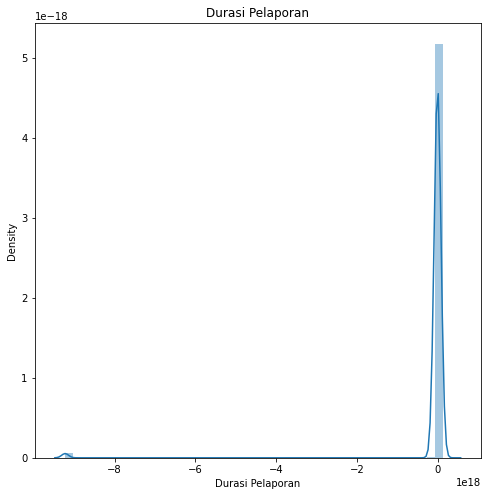

In [22]:
plt.figure(figsize = (8,8))
sns.distplot(df['Durasi Pelaporan'])
plt.title('Durasi Pelaporan')

Dapat disimpulkan bahwa data Durasi Pelaporan terdistribusi normal

## Analisa

#### Bandara apa dengan nilai null tertinggi?

In [23]:
x=[]
for h, i  in enumerate(df["Airport Name"].drop_duplicates()):
    no = 0
    no2 = 0
    bandara = (df[df['Airport Name'] == i ].count()["Claim Number"]) * 15
    no2 = no2 + bandara
    for j in df.columns:
        a = df[j][df["Airport Name"] == i].isna().sum()
        no = no + a
    x.append([i,no, no2])
bandara = pd.DataFrame(x, columns=['Nama Bandara', 'Jumlah Null', 'Jumlah data'])

In [24]:
bandara['prosentase'] = ( bandara['Jumlah Null'] / bandara['Jumlah data']) * 100
plot = bandara.sort_values(by=['prosentase'], ascending=False).head(10)
plot

,Nama Bandara,Jumlah Null,Jumlah data,prosentase
470,Palmdale Regional,4,15,26.666667
467,L. M. Clayton Airport,3,15,20.000000
428,Unspecified Personal Injury,41,225,18.222222
227,Insurance Subrogation Claim,96,705,13.617021
479,Lea County Regional Airport,2,15,13.333333
441,Lancaster,2,15,13.333333
461,Dickinson Theodore Roosevelt Regional Airport,8,60,13.333333
466,Southeast Iowa Regional,2,15,13.333333
468,Roswell Industrial Air Center,2,15,13.333333
469,Show Low Regional Airport,4,30,13.333333


In [25]:
bandara[bandara['prosentase'] == 0]

,Nama Bandara,Jumlah Null,Jumlah data,prosentase
169,Laramie Regional,0,105,0.0
200,Chisolm-Hibbing Municipal,0,75,0.0
240,Mayaguez; PR,0,15,0.0
280,Klamath Falls Airport,0,135,0.0
281,Pocatello Regional,0,90,0.0
294,Mckellar-Sipes Regional,0,30,0.0
302,Boone County Regional Airport,0,15,0.0
316,Decatur; IL,0,105,0.0
325,Naples Municipal Airport,0,30,0.0
335,Grant County,0,15,0.0


In [26]:
bandara[bandara['prosentase'] == 0]["prosentase"].count()

30

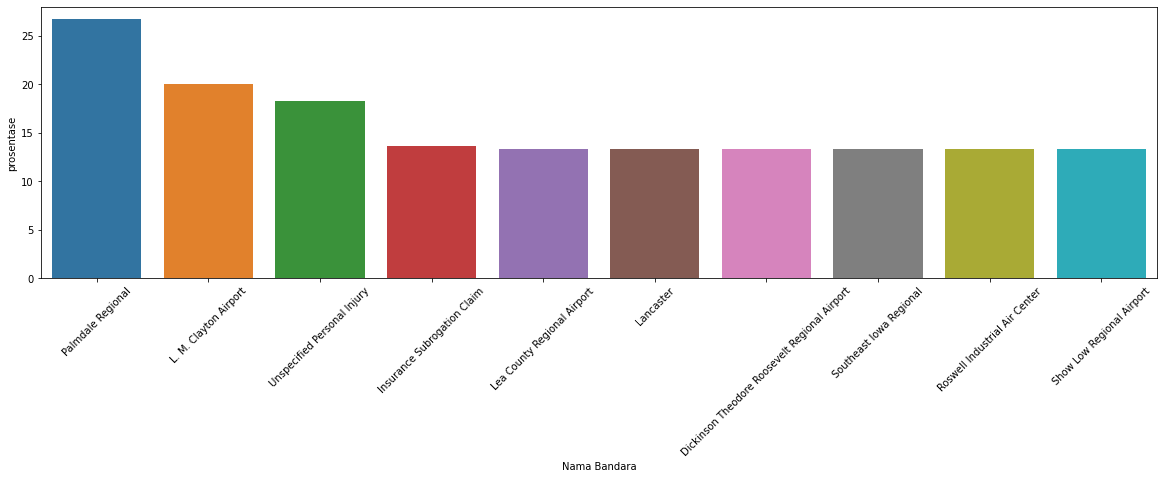

In [27]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(data=plot, x="Nama Bandara", y="prosentase")

plt.xticks(rotation=45)
plt.show()

Dari gambar diatas dapat disimpulan bahwa bandara Palmdale Regional	merupakan bandara dengan prosentase nilai null terbesar yaitu **26.67 %**. Perlu ditingkatkan tingkat kepedulian terhadap data pada bandara tersebut yang dapat menjadi acuan. Terdapat 30 bandara dengan tingkat akurasi data hingga **100%**.

#### Seperti apa tren insiden pesawat terbang?

In [28]:
df2 = df.dropna().copy()

In [29]:
df2['Received day'] = df2['Incident Date'].dt.weekday
df2['Received month'] = df2['Incident Date'].dt.month
df2['Received year Received'] = df2['Date Received'].dt.year
df2['Received year Incident'] = df2['Incident Date'].dt.year

In [30]:
# Dari informasi yang didapatkan dari keaggle bahwa data diambil pada tahun 2002 - 2015 sehingga data diatas tahun 2015 merupakan data yang salah.
df2 = df2[df2['Received year Received'] <= 2015]

In [31]:
df3 = df2.groupby(['Received year Received']).count()
df4 = df2.groupby(['Received year Incident']).count()


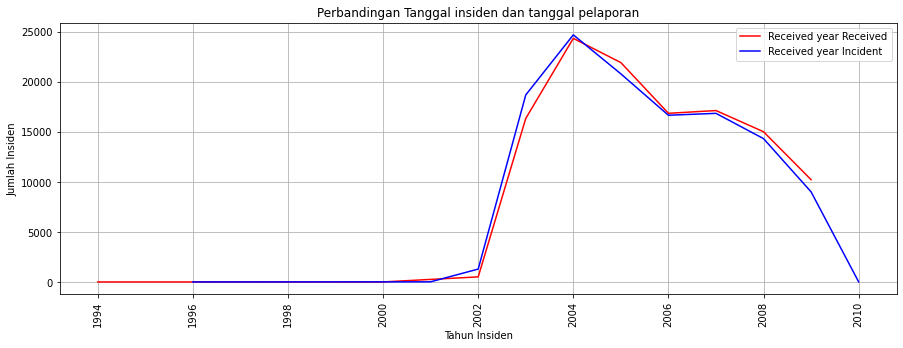

In [32]:
plt.figure(figsize=(15,5))
plt.plot( df3.index, df3['Claim Number'], 'red'
        ,
         df4.index, df4['Claim Number'], 'blue'
        )
plt.xlabel("Tahun Insiden")
plt.ylabel("Jumlah Insiden")
plt.title ("Perbandingan Tanggal insiden dan tanggal pelaporan")
plt.xticks(rotation=90)
plt.legend(["Received year Received",'Received year Incident'])
plt.grid(True)
plt.show()

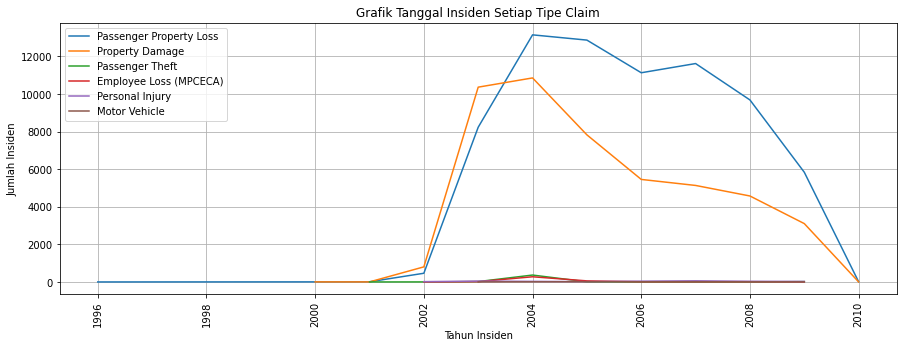

In [42]:
df8 = df2.groupby(['Received year Incident','Claim Type' ]).count().reset_index()
plt.figure(figsize=(15,5))
x = []
for i in df8["Claim Type"].unique():
   df9 = df8[df8["Claim Type"] == i] 
   plt.plot(  df9['Received year Incident'], df9['Claim Number'] ) 
   x.append(i)
plt.xlabel("Tahun Insiden")
plt.ylabel("Jumlah Insiden")
plt.title ("Grafik Tanggal Insiden Setiap Tipe Claim")
plt.xticks(rotation=90)
plt.legend(x)
plt.grid(True)
plt.show()
    

c:\Users\pudyo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


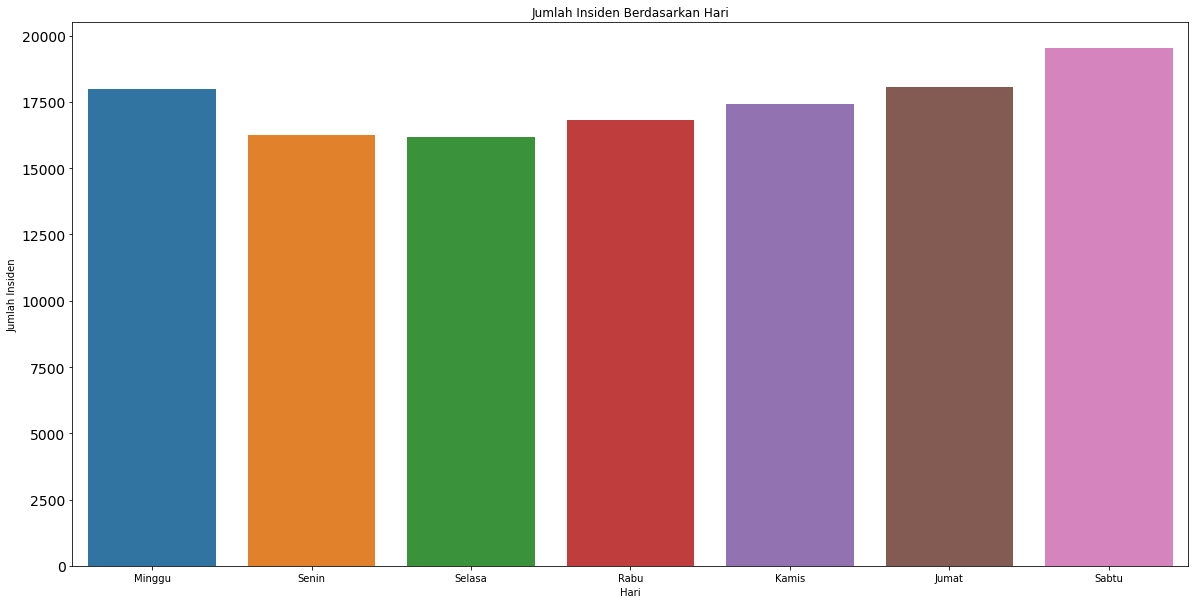

In [43]:
claims_count = df2['Received day'].value_counts()

plt.figure(figsize=(20,10))
sns.barplot(claims_count.index, claims_count.values)
plt.xlabel('Hari')
plt.ylabel('Jumlah Insiden')
plt.title ("Jumlah Insiden Berdasarkan Hari")
plt.xticks(range(7), ['Minggu', 'Senin', 'Selasa', 'Rabu', 'Kamis', 'Jumat', 'Sabtu'])
plt.yticks(fontsize=14)
plt.show()

c:\Users\pudyo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


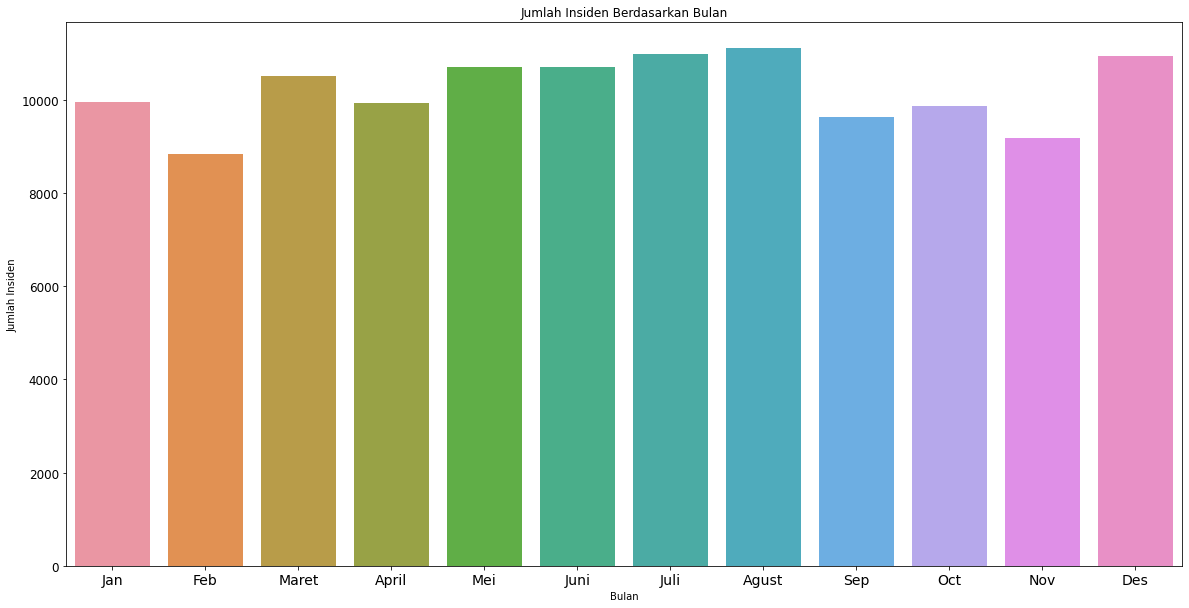

In [44]:
claims_count2 = df2['Received month'].value_counts()
months = ['Jan', 'Feb', 'Maret', 'April', 'Mei', 'Juni', 'Juli', 'Agust', 'Sep', 'Oct', 'Nov', 'Des']

plt.figure(figsize=(20,10))
sns.barplot(claims_count2.index, claims_count2.values)
plt.xlabel('Bulan')
plt.ylabel('Jumlah Insiden')
plt.title ("Jumlah Insiden Berdasarkan Bulan")
plt.xticks(range(12), months, fontsize=14)
plt.yticks(fontsize=12)
plt.show()

Jumlah kecelakaan dari tahun 2004 memiliki kecenderungan turun baik Insiden maupun pelaporannya yang di dominasi  **Passenger Property Loss** dan **Property Damage** walaupun belakangan ini memiliki tren yang menurun. Kecelakaan paling sering terjadi pada hari **Sabtu** dan pada bulan **Agustus**.

#### Bandara apa dengan insiden tertinggi?

c:\Users\pudyo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


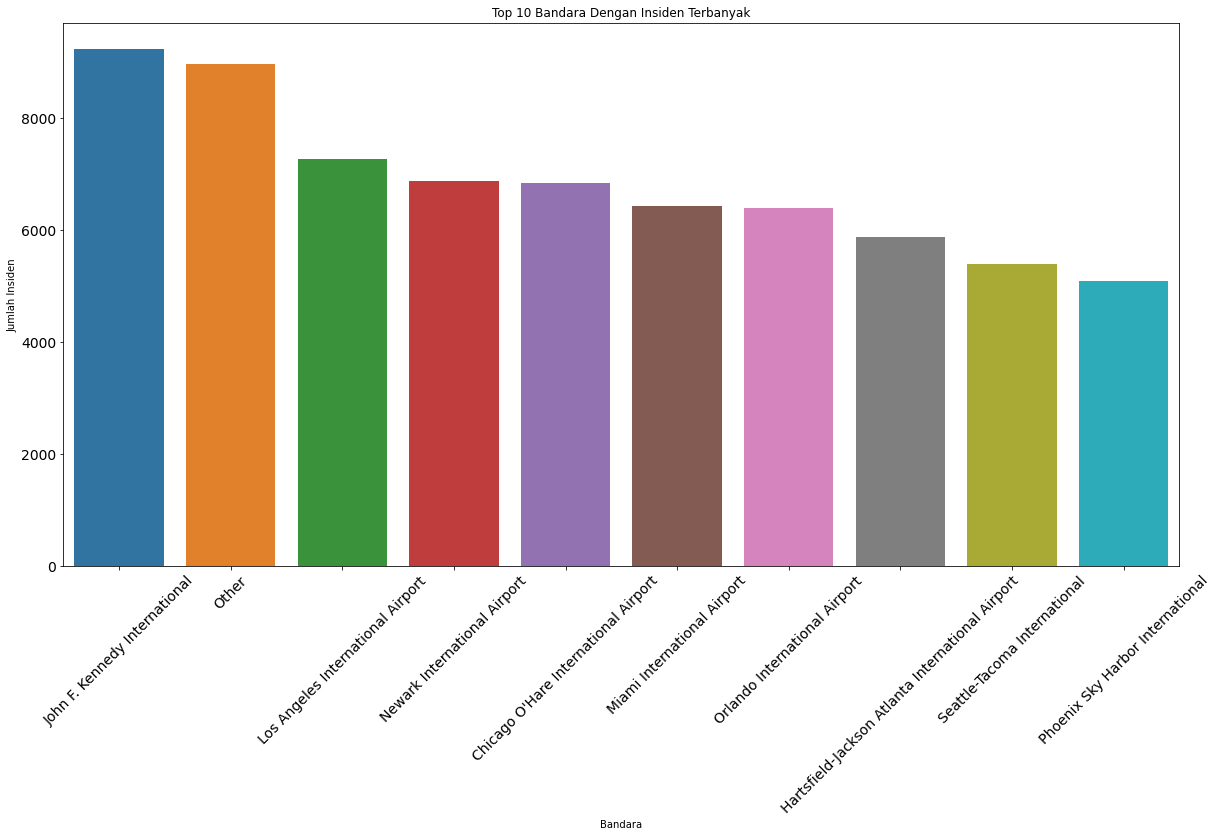

In [46]:
claims_count = df['Airport Name'].value_counts()
claims_count = claims_count.head(10)

plt.figure(figsize=(20,10))
sns.barplot(claims_count.index, claims_count.values)
plt.xlabel('Bandara')
plt.title ("Top 10 Bandara Dengan Insiden Terbanyak")
plt.ylabel('Jumlah Insiden')
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.show()

Dari data diatas dapat dilihat bahwa bandara **John F. Kennedy International** adalah bandara dengan tingkat insiden tertinggi. Hal tersebut dapat dikatakan normal karena dilansir dari [jfkairport.net](https://jfkairport.net/statistics/#:~:text=Statistics%20for%20JFK%20Airport&text=15%2C200%2C286%20passengers%20used%20JFK%20Airport,compared%20to%202020%20(8%2C272%2C328).&text=How%20many%20passengers%20use%20JFK%20Airport%20every%20month%3F,to%20March%202021%20(712%2C183).) bahwa pada tahun 2021 bandara tersebut mengangkut setidaknya **15,200,286** penumpang.

#### Maskapai penerbangan apa dengan tingkat kecelakaan paling banyak?

c:\Users\pudyo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


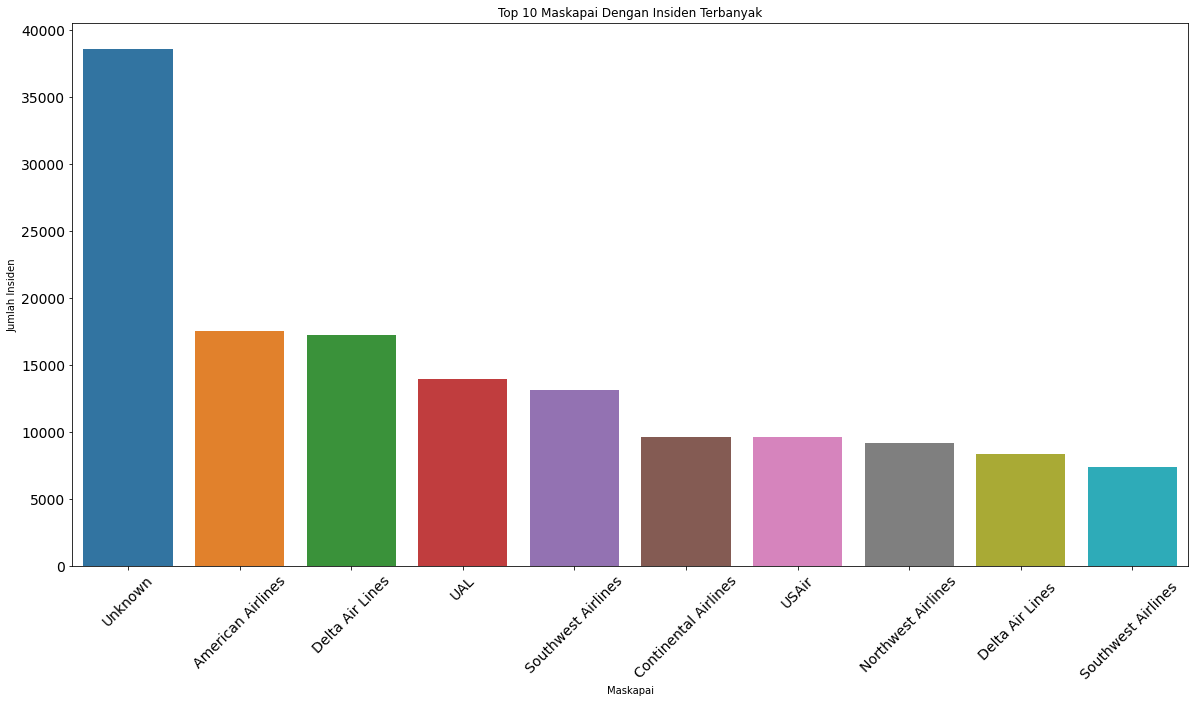

Unknown                 38616
American Airlines       17553
Delta Air Lines         17223
UAL                     13993
Southwest Airlines      13162
Continental Airlines     9674
USAir                    9621
Northwest Airlines       9215
Delta Air Lines          8365
Southwest Airlines       7378
Name: Airline Name, dtype: int64


In [47]:
maskapai = df['Airline Name'].value_counts()
maskapai = maskapai.head(10)

plt.figure(figsize=(20,10))
sns.barplot(maskapai.index, maskapai.values)
plt.xlabel('Maskapai')
plt.ylabel('Jumlah Insiden')
plt.title ("Top 10 Maskapai Dengan Insiden Terbanyak")
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.show()

print (maskapai)

Dapat dilihat bahwa banyak maskapai yang tidak diketahui namanya mengalami insiden, sementara itu maskapai dengan tingkat insiden terbanyak adalah **American Airlines dengan 17553 kasus ** dan **Delta Airline dengan 17223 kasus**

#### Bandara mana yang memiliki jumlah permintaan ganti rugi terbanyak?

In [38]:
air = df2[df2["Airport Name"] != "Other"].groupby(['Airport Name']).sum()
# airb = air[air["Airport Name"] != "Other"]
airport = air.sort_values(['Claim Amount'], ascending= False). head(10)
airport

,Claim Amount,Close Amount,selisih,Received day,Received month,Received year Received,Received year Incident
Airport Name,,,,,,,
Phoenix Sky Harbor International,1.263933e+08,254146.83,1.261391e+08,9651,20306,6421997,6421584
Los Angeles International Airport,1.064964e+08,684590.23,1.058118e+08,18295,37768,11878184,11877465
John F. Kennedy International,2.920259e+07,461340.96,2.874125e+07,14187,30505,9240049,9239475
LaGuardia,1.290577e+07,318843.74,1.258692e+07,7789,17219,5158064,5157733
TSA - Non-Specified Airport,1.003795e+07,20798.49,1.001715e+07,181,408,110225,110213
Sacramento International Airport,8.590342e+06,83133.92,8.507208e+06,2711,5779,1726929,1726819
McCarran International,7.948167e+06,473446.43,7.474720e+06,9745,19965,6200689,6200398
Philadelphia International Airport,5.501257e+06,257420.22,5.243837e+06,9348,20308,6053411,6053082
Seattle-Tacoma International,4.534996e+06,345728.17,4.189268e+06,10269,22733,6824890,6824453


c:\Users\pudyo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


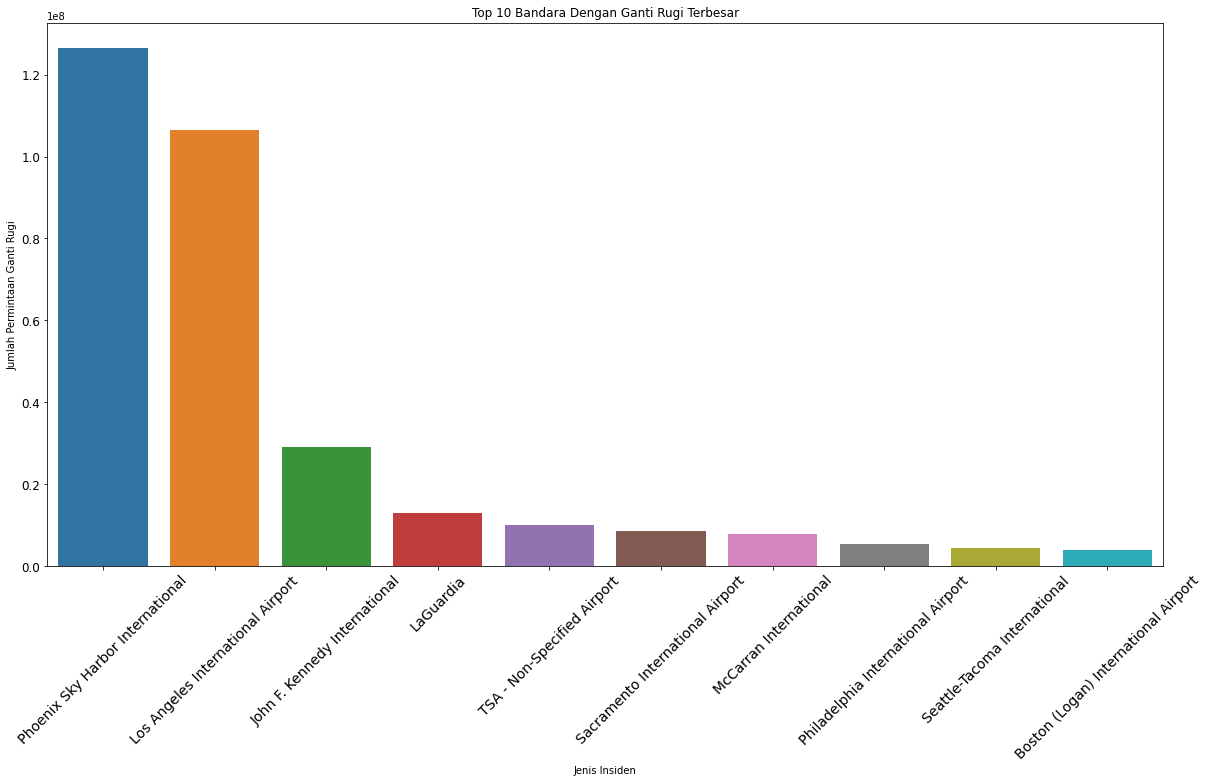

In [48]:
y = airport['Claim Amount']
labels = airport.index



plt.figure(figsize=(20,10))
sns.barplot(labels, y)
plt.xlabel('Jenis Insiden')
plt.ylabel('Jumlah Permintaan Ganti Rugi')
plt.title ("Top 10 Bandara Dengan Ganti Rugi Terbesar")
plt.xticks( fontsize=14, rotation=45)
plt.yticks(fontsize=12)
plt.show()

**Phoenix Sky Harbor International** dan **Los Angeles International Airport** adalah urutan teratas dari permintaan ganti rugi penumpang dengan masing masing sekitar **120 Juta USD** dan **100 Juta USD**

#### Tipe pengaduan apa yang memiliki jumlah permintaan ganti rugi tertinggi dan seperti apa prosentase ganti rugi diterima atau tidak??

c:\Users\pudyo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


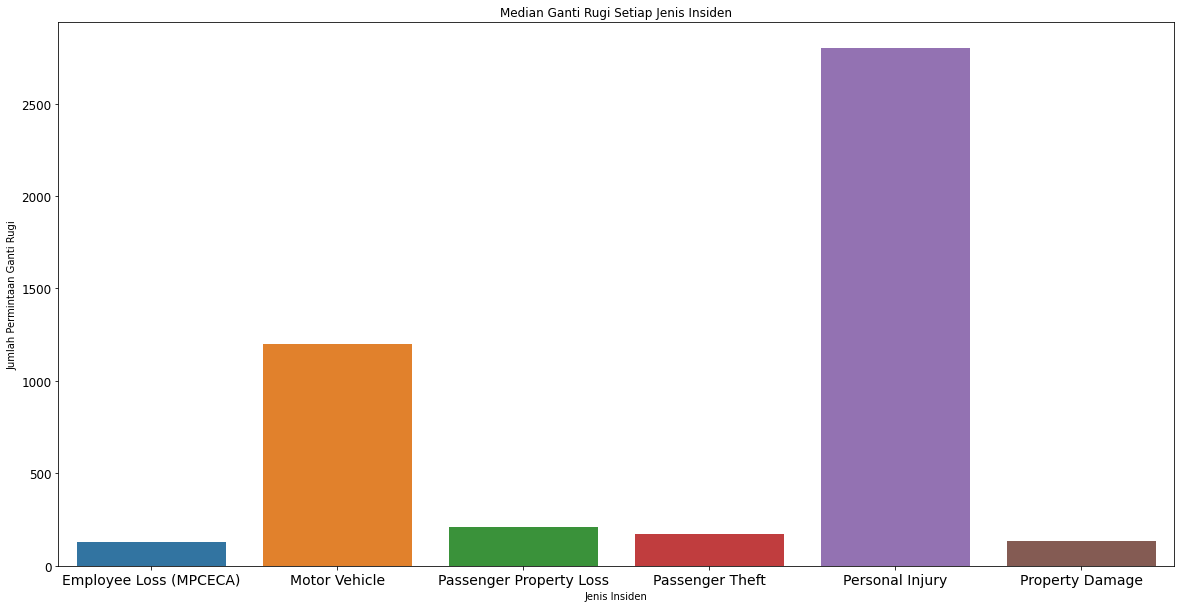

,Claim Amount,Close Amount,selisih,Received day,Received month,Received year Received,Received year Incident
Claim Type,,,,,,,
Employee Loss (MPCECA),129.990,29.420,19.06,3.0,5.0,2004.0,2004.0
Motor Vehicle,1198.775,627.175,0.00,2.5,7.0,2007.0,2006.5
Passenger Property Loss,209.000,0.000,127.17,3.0,7.0,2006.0,2006.0
Passenger Theft,170.000,32.460,88.67,3.0,7.0,2004.0,2004.0
Personal Injury,2800.000,0.000,2500.00,3.0,7.0,2007.0,2006.0
Property Damage,132.300,22.450,58.00,3.0,7.0,2005.0,2005.0


In [52]:
pie2 = df2.groupby(['Claim Type']).median()
pie2.sort_values(['Claim Amount'], ascending= False)
y = pie2['Claim Amount']
labels = pie2.index



plt.figure(figsize=(20,10))
sns.barplot(labels, y)
plt.xlabel('Jenis Insiden')
plt.ylabel('Jumlah Permintaan Ganti Rugi')
plt.title ("Median Ganti Rugi Setiap Jenis Insiden")
plt.xticks( fontsize=14)
plt.yticks(fontsize=12)
plt.show()
pie2

c:\Users\pudyo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


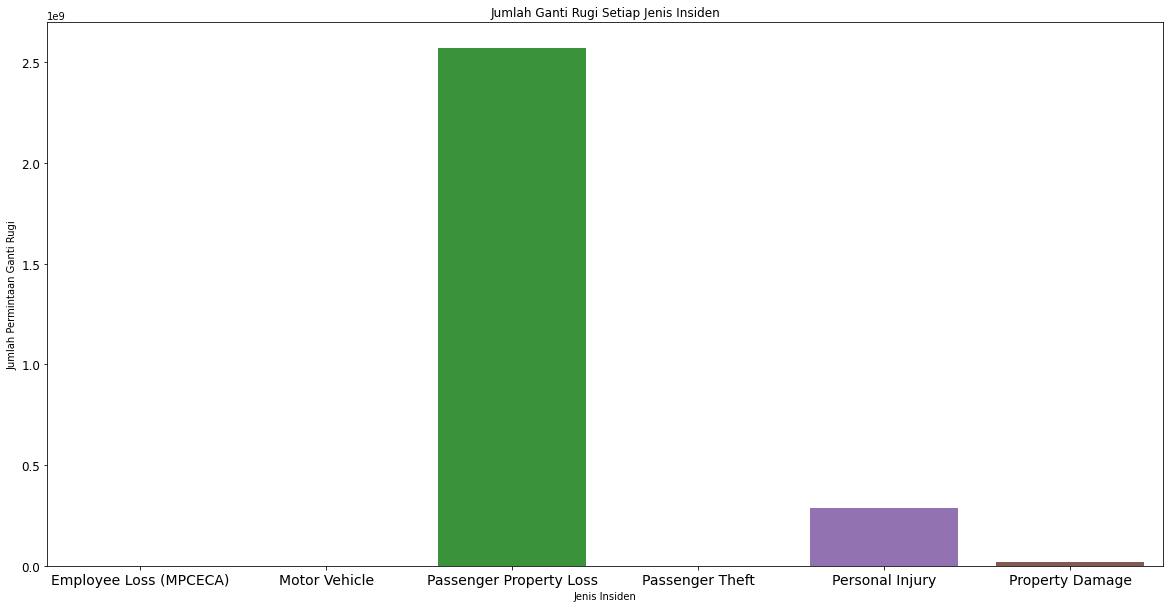

,Claim Amount,Close Amount,selisih,Received day,Received month,Received year Received,Received year Incident
Claim Type,,,,,,,
Employee Loss (MPCECA),2.389114e+05,45565.88,1.933455e+05,1190,2125,795796,795773
Motor Vehicle,9.535397e+04,68658.52,2.669545e+04,157,389,116387,116372
Passenger Property Loss,2.569644e+09,6360234.50,2.563283e+09,225336,478997,146402977,146394650
Passenger Theft,3.017442e+05,62234.98,2.395092e+05,1281,2914,843784,843763
Personal Injury,2.878226e+08,136228.18,2.876864e+08,807,1898,559719,559604
Property Damage,2.043551e+07,4750952.48,1.568456e+07,147472,313108,96489024,96482434


In [54]:
pie = df2.groupby(['Claim Type']).sum()
pie.sort_values(['Claim Amount'], ascending= False)
y = pie['Claim Amount']
labels = pie.index



plt.figure(figsize=(20,10))
sns.barplot(labels, y)
plt.xlabel('Jenis Insiden')
plt.title ("Jumlah Ganti Rugi Setiap Jenis Insiden")
plt.ylabel('Jumlah Permintaan Ganti Rugi')
plt.xticks( fontsize=14)
plt.yticks(fontsize=12)
plt.show()
pie

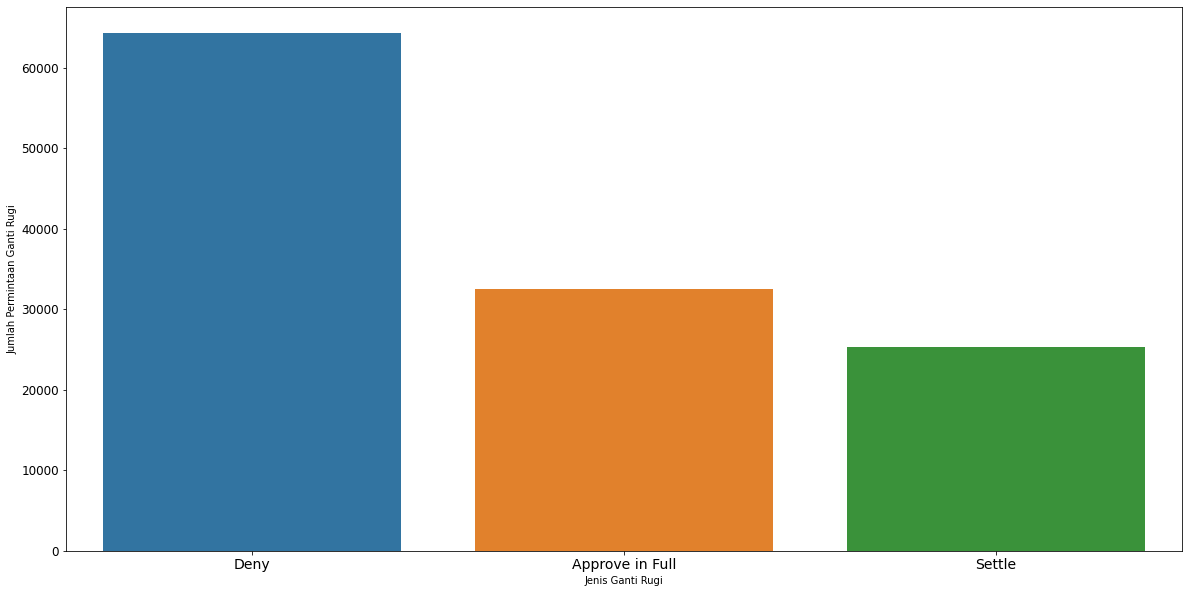

                 Claim Amount  prosentase
Disposition                              
Deny                    64325   52.613714
Approve in Full         32565   26.636076
Settle                  25369   20.750211


In [ ]:
aduan = df2.groupby(['Disposition']).count()
aduan = aduan.sort_values(['Claim Amount'], ascending= False)
aduan['prosentase'] = (aduan["Claim Amount"]/aduan["Claim Amount"].sum())*100
plt.figure(figsize=(20,10))
sns.barplot(data=aduan, x=aduan.index, y="Claim Amount", errwidth=0)
plt.xlabel('Jenis Ganti Rugi')
plt.ylabel('Jumlah Permintaan Ganti Rugi')
plt.xticks( fontsize=14)
plt.yticks(fontsize=12)
plt.show()
print (aduan[['Claim Amount','prosentase']])

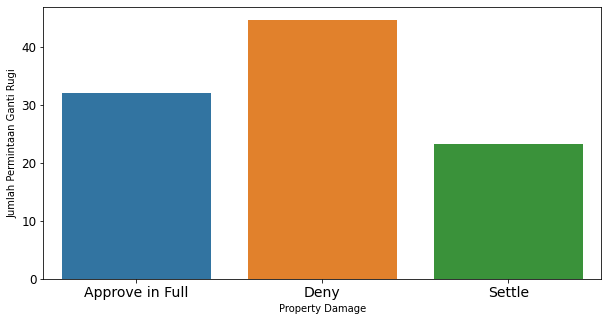

       Disposition  Prosentase
0  Approve in Full   32.117547
1             Deny   44.678596
2           Settle   23.203857
Rasio claim Property Damage untuk di terima adalah 55.32 %


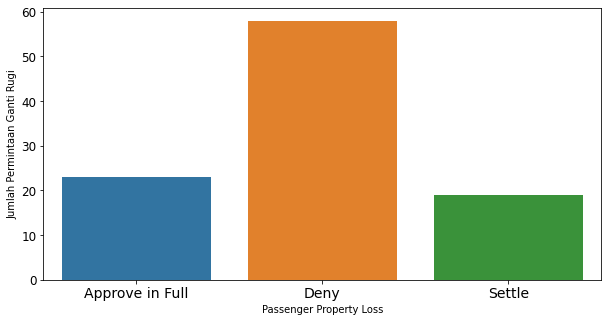

       Disposition  Prosentase
0  Approve in Full   22.953403
1             Deny   57.958267
2           Settle   19.088331
Rasio claim Passenger Property Loss untuk di terima adalah 42.04 %


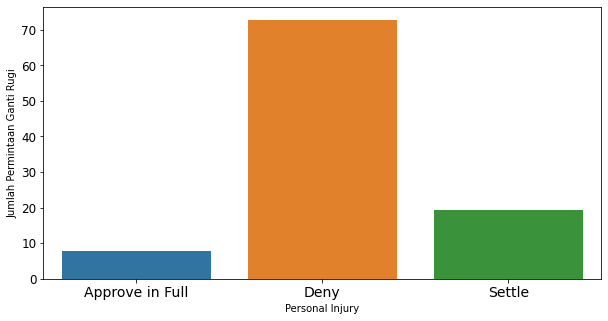

       Disposition  Prosentase
0  Approve in Full    7.885305
1             Deny   72.759857
2           Settle   19.354839
Rasio claim Personal Injury untuk di terima adalah 27.24 %


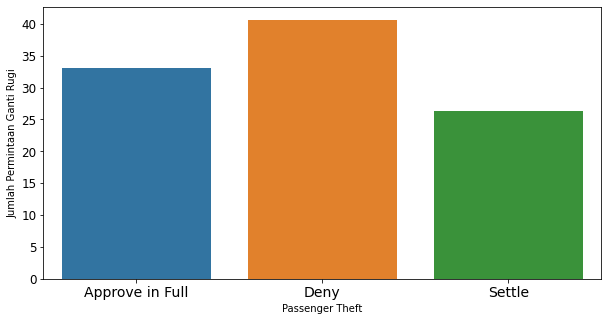

       Disposition  Prosentase
0  Approve in Full   33.016627
1             Deny   40.617577
2           Settle   26.365796
Rasio claim Passenger Theft untuk di terima adalah 59.38 %


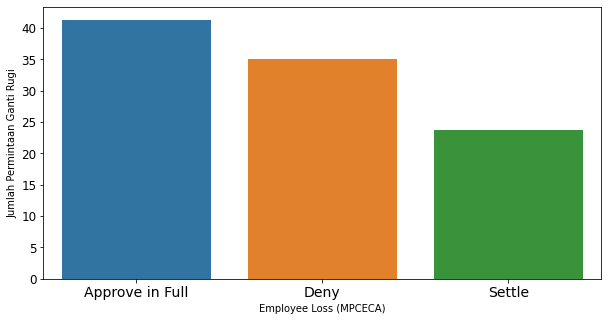

       Disposition  Prosentase
0  Approve in Full   41.309824
1             Deny   35.012594
2           Settle   23.677582
Rasio claim Employee Loss (MPCECA) untuk di terima adalah 64.99 %


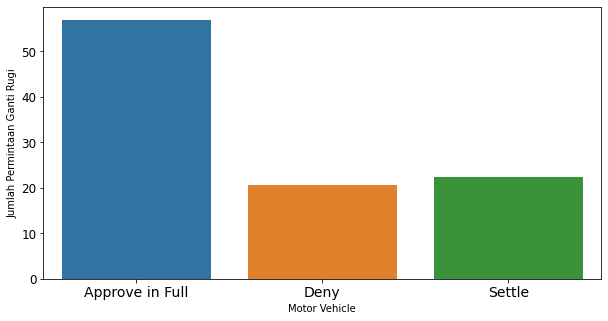

       Disposition  Prosentase
0  Approve in Full   56.896552
1             Deny   20.689655
2           Settle   22.413793
Rasio claim Motor Vehicle untuk di terima adalah 79.31 %


In [ ]:
for i in df2['Claim Type'].unique():
    plt.figure(figsize=(10,5))
    samples = df2[df2['Claim Type'] == i].groupby(['Disposition']).count().reset_index()
    samples['Prosentase'] = (samples["Claim Amount"]/samples["Claim Amount"].sum())*100
    sns.barplot(data=samples, x='Disposition', y="Prosentase", errwidth=0)
    plt.xlabel(i)
    plt.ylabel('Jumlah Permintaan Ganti Rugi')
    plt.xticks( fontsize=14)
    plt.yticks(fontsize=12)
    plt.show()
    print(pd.DataFrame(samples[['Disposition','Prosentase']], columns=[ 'Disposition','Prosentase']))
    a = 100 - (samples[samples["Disposition"] == 'Deny']["Prosentase"])
    print (f'Rasio claim {i} untuk di terima adalah {round(a.values[0],2)} %')

In [56]:
settle = df2[df2['Disposition'] == 'Settle']
settle1 = settle.groupby(['Claim Type']).sum()
settle2 = settle.groupby(['Claim Type']).count()
settle3 = settle1.copy()
settle3['selisihh'] = settle1['selisih']
settle3['Jumlan Kecelakaan'] = settle2['Claim Amount']
settle3['rasio'] = (settle3['Jumlan Kecelakaan'] / settle3['selisih'])
settle3

,Claim Amount,Close Amount,selisih,Received day,Received month,Received year Received,Received year Incident,selisihh,Jumlan Kecelakaan,rasio
Claim Type,,,,,,,,,,
Employee Loss (MPCECA),41302.74,22529.32,18773.42,304,525,188407,188400,18773.42,94,0.005007
Motor Vehicle,26407.81,14691.13,11716.68,34,81,26073,26071,11716.68,13,0.001110
Passenger Property Loss,7467065.78,3383464.66,4083601.12,43033,89496,27933375,27931823,4083601.12,13932,0.003412
Passenger Theft,75543.16,45150.32,30392.84,372,784,222442,222438,30392.84,111,0.003652
Personal Injury,1064588.17,103636.65,960951.52,159,394,108290,108273,960951.52,54,0.000056
Property Damage,4634002.06,2210075.51,2423926.55,34317,71722,22383119,22381669,2423926.55,11165,0.004606


c:\Users\pudyo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


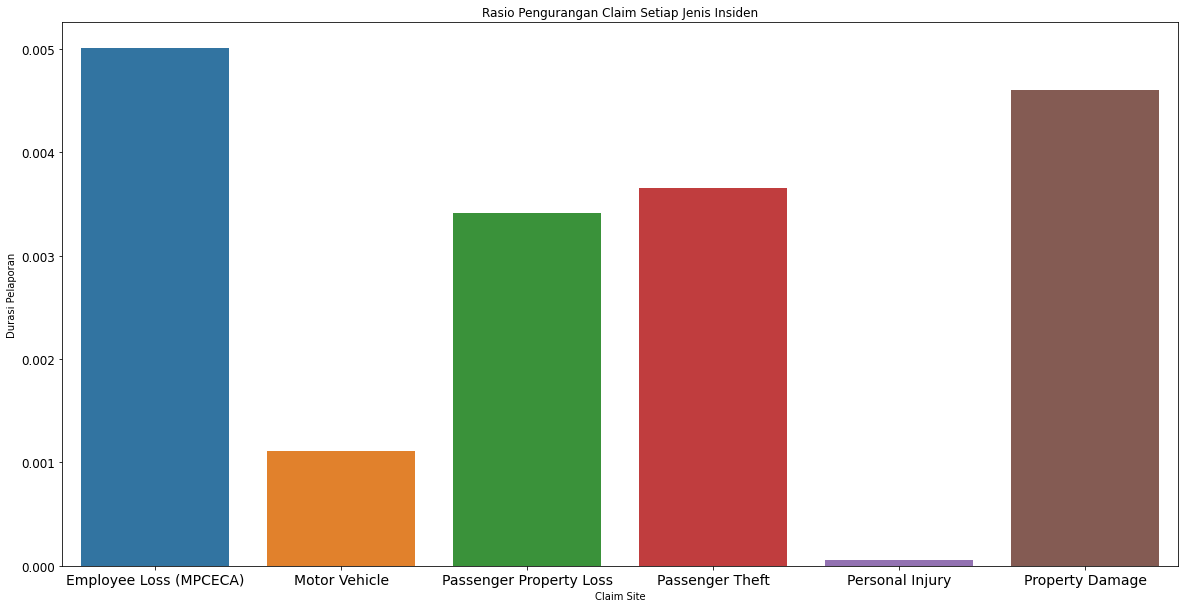

In [57]:
y = settle3['rasio']
labels = settle3.index



plt.figure(figsize=(20,10))
sns.barplot(labels, y)
plt.xlabel('Claim Site')
plt.title ("Rasio Pengurangan Claim Setiap Jenis Insiden")
plt.ylabel('Durasi Pelaporan')
plt.xticks( fontsize=14)
plt.yticks(fontsize=12)
plt.show()

Dari grafik diatas dapat dilihat bahwa sebagian besar pengaduan akan di tolak dengan prosentase penolakan hingga **52.61 %**. **Passenger Property Loss** merupakan Jumlah Permintaan Ganti Rugi paling dominan diantara yang lain dengan nominal hampir **2.6 Milyar USD**, sedangkan rata - rata permintaan ganti rugi terbesar adalah **Personal Injury** dengan nilai sekitar **2800 USD**. Selain itu dapat dilihat juga bahwa **Personal Injury** menjadi tingkat penolakan ganti rugi terbesar yaitu **72.76%** sedangkan tingkat penolakan ganti rugi terkecil adalah **Motor Vehicle** yaitu sebesar **79.31 %**. **Personal Injury** merupakan rasio terkecil dengan rasio pembayaran yang tidak sesuai dengan permintaan sebanyak yaitu **0.000056**

# Kesimpulan dan Rekomendasi 

## Kesimpulan
Dari analisis yang telah dilakukan, dapat ditarik kesimpulan tentang insiden pesawat terbang sebagai berikut:
1. Tingkat insiden akan sebanding lurus dengan jumalah penumpang, terlihat dari jumlah penumpang pada bandara terpadat, bulan yang paling sering di gunakannya transportasi udara (Desember, July dan Agustus) dan hari yang paling sibuk (Sabtu).
2. Banyak terdapat insiden pada maskapai yang tidak ter-record dengan baik dan ada bandara yang tidak melakukan pengumpulan data dengan baik.
3. Personal Injury merupakan insiden dengan permintaan gantirugi yang cukup besar dan cenderung dipenuhi tanpa pengurangan sedangkan passanger property lost merupakan jenis kecelakaan dengan tingkat penolakan dan pengurangan harga dari permintaan yang paling besar.
4. Terjadi tren penurunan insiden pada beberapa tahun belakangan.
5. Insiden terbanyak adalah Passanger Property Lost dan Property Damage dimana pada tahun 2002 memiliki lonjakan yang cukup signifikan.
6. Motor Vehicle memiliki tingkat penolakan paling kecil

## Rekomendasi

1. Perlu ditingkatkan tingkat kepedulian tentang pelaporan dan pencatataan terhadap kecelakaan agar lebih mudah untuk di tanggulangi
2. Penekanan lebih lanjut pada maskapai penerbangan dan bandara tentang keamanan dan keselamatan terhadap barang dan jiwa penumpang.
3. Upaya untuk menekan Personal Injury perlu di tingkatkan melihat dari besarnya biya yang perlu dibayarkan apabila terjadi insiden.
4. Pessanger property lost juga perlu menjadi catatan tersendiri mengingat banyakya insiden yang terjadi dan hal tersebut.
5. Perlunya perhatian khusus pada waktu waktu peak season untuk mengurangi tingkat insiden, dan motor vehicle juga perlu mendapat perhatian karena tingkat penolakan yang relatif kecil sehingga dapat mengurangi pengeluaran cost perusahaan.
